In [103]:
import numpy as np
import matplotlib.pyplot as plt
import ktransit
from ktransit import FitTransit, LCModel

%matplotlib inline

In [104]:
time, flux = np.genfromtxt('lc.txt').T

In [135]:
time0 = time[0]

fitT = FitTransit()

fitT.add_guess_star(
    rho = 1.606, 
    ld1 = 0.627716437951, 
    ld2 = 0.454717504099,
    zpt=0.0)



fitT.add_guess_planet(
    period=3.560130617,
    impact=0.1,
    T0=2457740.32-time0,
    rprs=0.0262725683,)

fitT.add_guess_planet(
    period=5.405518809,
    impact=0.1,
    T0=2457743.155-time0,
    rprs=0.0277950331,)

fitT.add_guess_planet(
    period=8.26189452,
    impact=0.1,
    T0=2457740.644-time0,
    rprs=0.0353628652,)

fitT.add_guess_planet(
    period=12.758809,
    impact=0.1,
    T0=2457738.699-time0,
    rprs=0.038595707,)


fitT.add_data(
    time=time-time0,
    flux=flux-1.0,
    itime=np.ones_like(time) * 0.0188
)

In [136]:
vary_star = ['rho', 'zpt']
vary_planet = ['period', 'impact', 'rprs', 'T0']

fitT.free_parameters(vary_star, vary_planet)

In [137]:
fitT.do_fit()

In [138]:
fitT.print_results()

Best-fitting stellar parameters
rho: 2.2275751700844917
zpt: 3.467187575477235e-05

Best-fitting planet parameters for planet 0
period: 3.5599819408147613
impact: 0.32963581059689356
rprs: 0.02241511151604781
T0: 1.9449216658374124

Best-fitting planet parameters for planet 1
period: 5.404899987680983
impact: -0.021363555722152806
rprs: 0.02307805267319707
T0: 4.780141435257812

Best-fitting planet parameters for planet 2
period: 8.26125506330193
impact: 0.3918982829628246
rprs: 0.031133763111158657
T0: 2.2704625464066233

Best-fitting planet parameters for planet 3
period: 12.757077544064162
impact: 0.5825683470621746
rprs: 0.025208972724532347
T0: 0.327814233018034



In [139]:
np.max(fitT.transitmodel)- np.min(fitT.transitmodel)

0.0012785704238907902

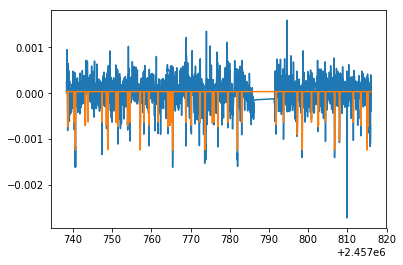

In [140]:
plt.plot(time,flux-1.0)
plt.plot(time,fitT.transitmodel)

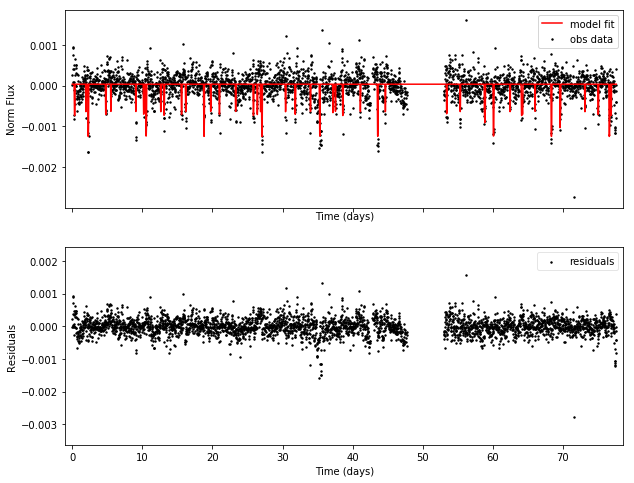

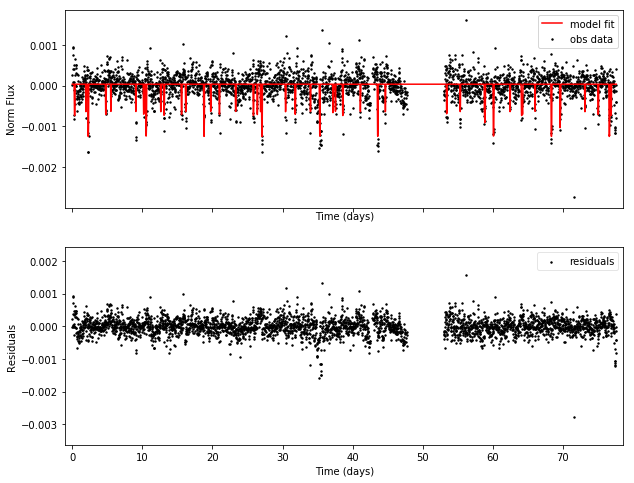

In [141]:
ktransit.plot_results(time-time0,flux-1.0,fitT.transitmodel)

In [142]:
def get_qf(time,flux,epoch,period,transitmodel=None):
    date1 = (time - epoch) + 0.5*period
    phi1 = (((date1 / period) - np.floor(date1/period)) * period) - 0.5*period
    q1 = np.sort(phi1)
    f1 = (flux[np.argsort(phi1)]) * -1.E6
    if transitmodel is not None:
        m1 = (transitmodel[np.argsort(phi1)]) * -1.E6
        return q1,f1,m1
    else:
        return q1,f1

def plot_model(ax,time,flux, rho, zpt, ld1, ld2, fitresultsplanet, cadence='long'):

    T0=fitresultsplanet['T0']
    period=fitresultsplanet['period']
    q1, f1 = get_qf(time,flux,T0,period)

    model = model_ktransit(time, rho, zpt, ld1, ld2, fitresultsplanet, cadence=cadence)
    q1, m1 = get_qf(time,model,T0,period)
    ax.scatter(q1*24., f1/10000,color='k',alpha=period**0.5/5,s=4
              )
    ax.plot(q1*24., m1/10000,color='r')
    bq, bf, be = bin_data(q1,f1,bins=50.//period)
    ax.errorbar(bq*24., bf/10000, yerr=be/10000, ls='',color='b')
    ax.set_xlim([-4,4])
    ax.set_ylim([1.19,-0.75])
    #ax.set_xlabel('Time from mid-transit (days)')
    ax.set_ylabel('Transit depth (%)', fontsize=17)
    ax.minorticks_on()
    return ax

def bin_data(phi,flux,bins,model=None):
    phi = np.array(phi)
    flux = np.array(flux)
    phibin = []
    fluxbin = []
    stdbin = []
    bins=int(bins)
    for i in (bins*np.arange(len(phi)//bins))+(bins//2):
        if model == None:
            goodpoints = np.ones(len(flux),dtype=bool)
        else:
            goodpoints = flux-model < 3* np.std(flux-model)
        flux2 = flux[goodpoints]
        phi2 = phi[goodpoints]
        phibin.append(np.median(phi2[i-bins//2:i+bins//2]))
        fluxbin.append(np.median(flux2[i-bins//2:i+bins//2]))
        stdbin.append(np.std(flux2[i-bins//2:i+bins//2]))
    return np.array(phibin), np.array(fluxbin), np.array(stdbin) / np.sqrt(bins)

def model_ktransit(time, rho, zpt, ld1, ld2, fitresultsplanet, cadence):
    M = LCModel()
    M.add_star(rho=rho,zpt=zpt,ld1=ld1,
            ld2=ld2,dil=0)
    M.add_planet(T0=fitresultsplanet['T0'],
                 period=fitresultsplanet['period'],
                 impact=fitresultsplanet['impact'],
                 rprs=fitresultsplanet['rprs']
                 )
    if cadence == 'long':
        M.add_data(time=time, itime=np.ones_like(time) * 0.0188)
    elif cadence == 'short':
        M.add_data(time=time, itime=np.ones_like(time) * 0.0188 / 30)
    return M.transitmodel

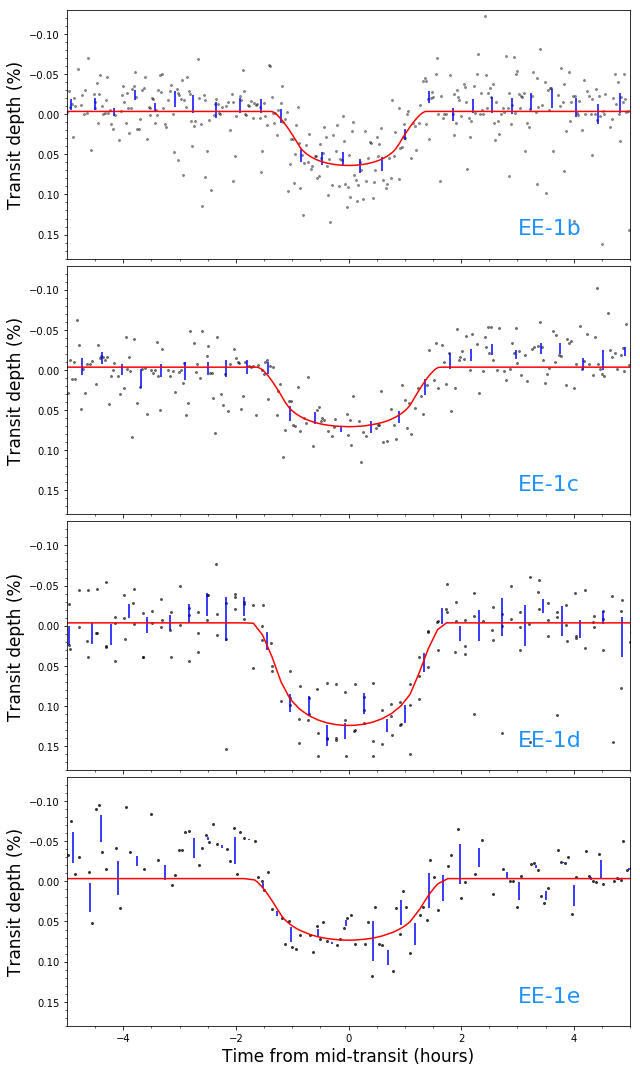

In [183]:
fig, axes = plt.subplots(4,1,figsize=[9,15], )

labels = ['EE-1b', 'EE-1c', 'EE-1d', 'EE-1e']
for i, p in enumerate(['pnum0', 'pnum1', 'pnum2', 'pnum3']):
    axes[i] = plot_model(
        axes[i], time-time0, flux-1.0, 
        fitT.fitresultstellar['rho'],
        fitT.fitresultstellar['zpt'],
        0.627716437951, 
        0.454717504099,
        fitT.fitresultplanets[p],
                        )
    
    axes[i].set_ylim(0.18,-0.13)
    axes[i].set_xlim(-5,5)
    axes[i].text(3.0,0.15, labels[i], fontsize=22, color='dodgerblue')
    axes[i].tick_params(labelbottom=False)

axes[-1].tick_params(labelbottom=True)
axes[-1].set_xlabel('Time from mid-transit (hours)', fontsize=17)
fig.subplots_adjust(hspace=0)
plt.tight_layout(h_pad=0)

fig.savefig('EE1-transits.png', dpi=200)

In [158]:

for i, p in enumerate(['pnum0', 'pnum1', 'pnum2', 'pnum3']):
    print('{} = {:.2f} Re'.format(labels[i], fitT.fitresultplanets[p]['rprs'] * 0.807 / 0.009155))

EE-1b = 1.98 Re
EE-1c = 2.03 Re
EE-1d = 2.74 Re
EE-1e = 2.22 Re


In [159]:
def get_ar(rho,period):
   """ gets a/R* from period and mean stellar density"""
   G = 6.67E-11
   rho_SI = rho * 1000.
   tpi = 3. * np.pi
   period_s = period * 86400.
   part1 = period_s**2 * G * rho_SI
   ar = (part1 / tpi)**(1./3.)
   return ar

In [167]:
for i, p in enumerate(['pnum0', 'pnum1', 'pnum2', 'pnum3']):
    per =  fitT.fitresultplanets[p]['period']
    ar = get_ar(fitT.fitresultstellar['rho'], per)
    print('{} = {:.3f} AU'.format(labels[i],ar * 0.807 * 0.00464913034))

EE-1b = 0.043 AU
EE-1c = 0.057 AU
EE-1d = 0.075 AU
EE-1e = 0.100 AU
